In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
import optuna

In [2]:
df_train = pd.read_csv("C:/Users/ASUS-X515EP/Downloads/data_bank_marketing_campaign.csv")
df_train = df_train.drop_duplicates()
df_train.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


In [3]:
df_train_1 = pd.read_csv("C:/Users/ASUS-X515EP/Downloads/bank (1).csv")
df_train_1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df = pd.merge(df_train, df_train_1, on=df_train.columns.tolist(), how='left')
df.shape

(7818, 17)

In [6]:
df.poutcome.value_counts()

poutcome
unknown    5824
failure     848
success     761
other       385
Name: count, dtype: int64

In [5]:
df['pdays'] = df['pdays'].replace(-1, 0)
for i in df.columns:
    if df[i].dtype=='object':
        df[i] = df[i].astype('category')
    elif df[i].dtype=='int64':
        df[i] = df[i].astype('int16')

df["month"] = df["month"].cat.reorder_categories(
                                                  new_categories=['jan', 'feb', 'mar', 'apr',
                                                                  'may', 'jun', 'jul', 'aug',
                                                                  'sep', 'oct', 'nov', 'dec'],
                                                  ordered=True)

df["month"].value_counts()

month
may    1978
aug    1088
jul    1050
jun     857
apr     662
nov     657
feb     534
oct     286
jan     227
sep     212
mar     199
dec      68
Name: count, dtype: int64

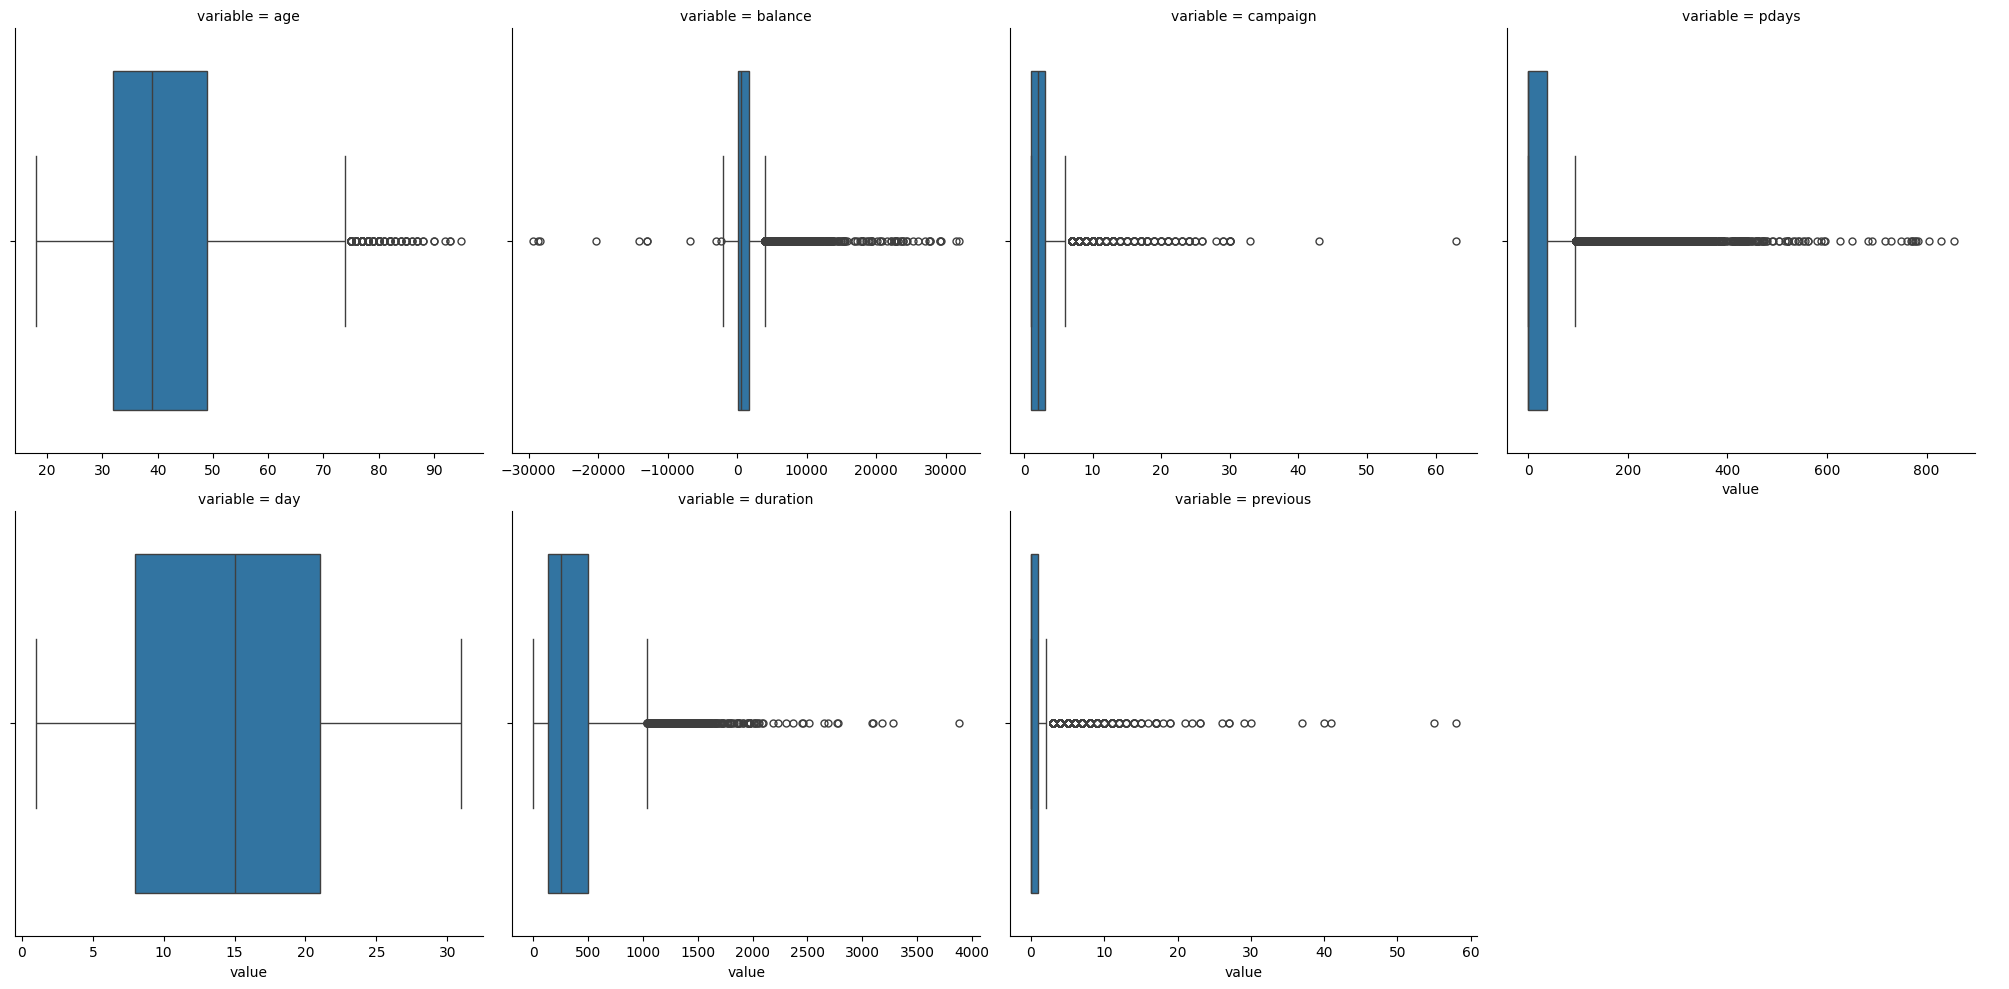

In [10]:
melted_df = df.melt(value_vars=df.select_dtypes(include='int16').columns)

sns.catplot(data=melted_df,
            x='value',
            col='variable',
            kind='box',
            col_wrap=4,
            sharex=False, sharey=False)

plt.show()

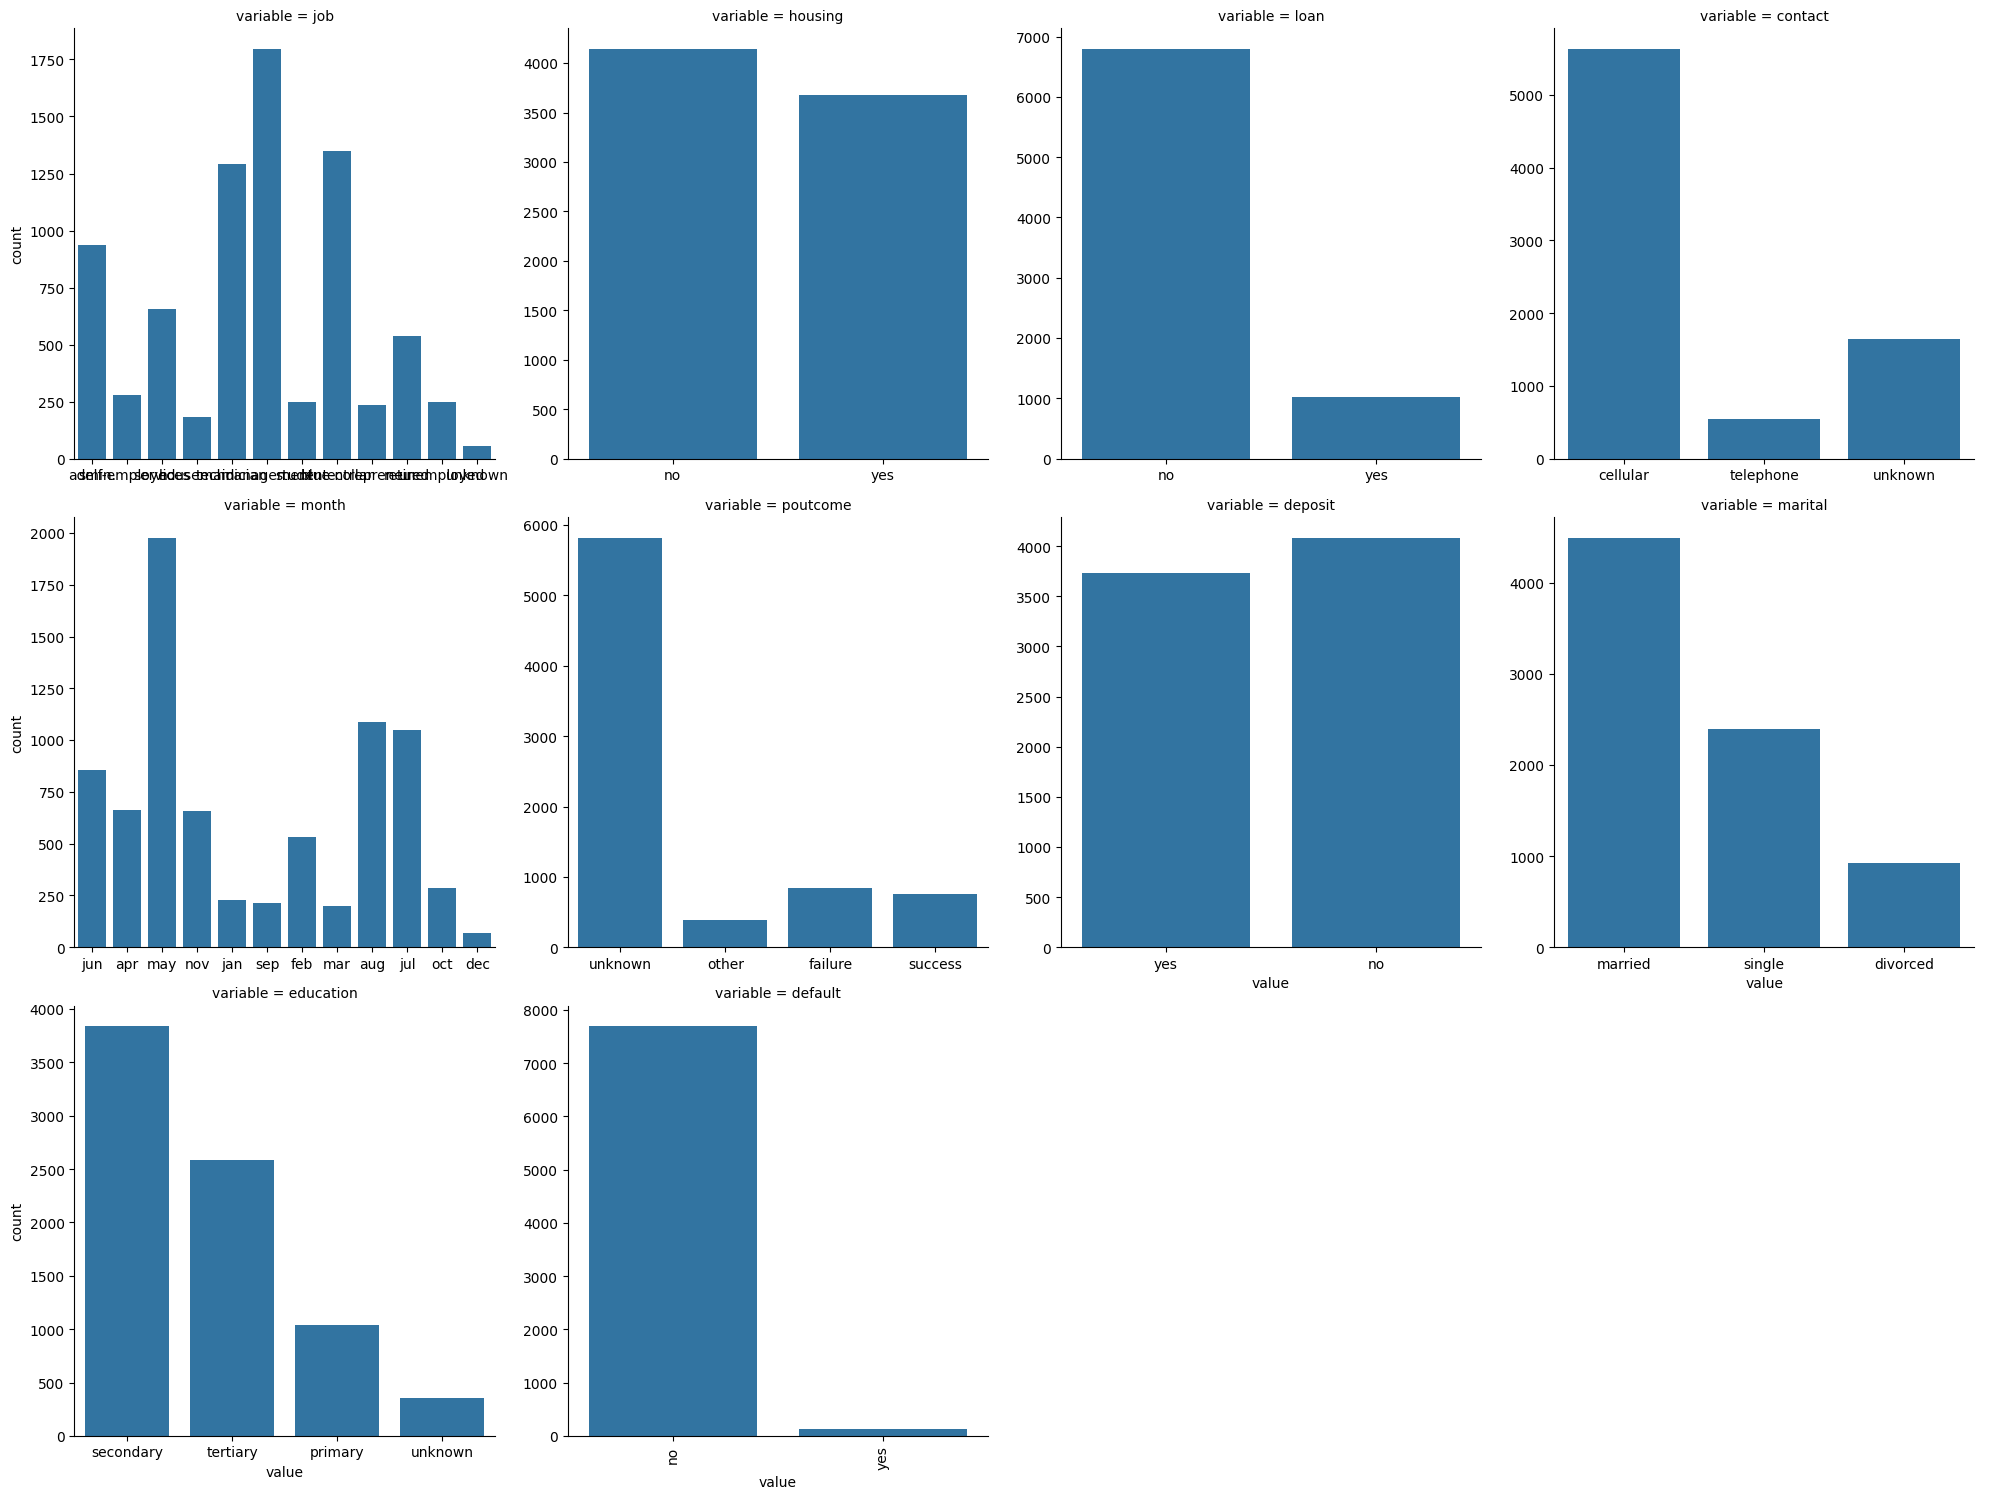

In [ ]:
melted_df = df.melt(value_vars=df.select_dtypes(include='category').columns)

sns.catplot(data=melted_df,
            x='value',
            col='variable',
            kind='count',
            col_wrap=4,
            sharex=False, sharey=False)

plt.xticks(rotation=90)
plt.show()

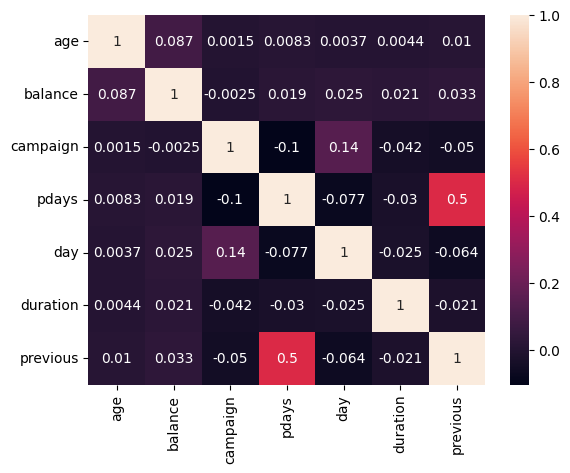

In [7]:
int_df = df.select_dtypes(include='int16')
sns.heatmap(int_df.corr(), annot=True)
plt.show()

In [6]:
df['deposit'] = LabelEncoder().fit_transform(df['deposit']).astype('int8')

list = ['housing', 'loan', 'default']
le = LabelEncoder()
for i in list:
    df[i] = LabelEncoder().fit_transform(df[i]).astype('int8')

In [7]:
df_new = df

ohe = OneHotEncoder(handle_unknown='ignore')
for i in df_new.columns:
    if df[i].dtype=='category':
        ohote = pd.get_dummies(df_new[i], prefix=i)
        df_new = pd.concat([df_new, ohote], axis=1)
        del df_new[i]
df_new

,age,balance,housing,loan,campaign,pdays,deposit,default,day,duration,...,poutcome_other,poutcome_success,poutcome_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
0,55,1662,0,0,2,0,1,0,4,94,...,False,False,True,False,True,False,False,True,False,False
1,39,-3058,1,1,3,0,1,0,17,882,...,False,False,True,False,True,False,False,False,True,False
2,51,3025,0,0,1,352,1,0,7,476,...,True,False,False,False,True,False,False,True,False,False
3,38,-87,1,0,1,0,0,0,13,531,...,False,False,True,False,False,True,True,False,False,False
4,36,205,1,0,4,0,0,0,18,176,...,False,False,True,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,62,2,0,0,1,0,1,0,3,322,...,False,False,True,False,True,False,False,True,False,False
7814,48,5473,0,0,2,184,1,0,24,127,...,False,True,False,False,True,False,False,False,True,False
7815,36,179,0,0,8,0,0,0,8,14,...,False,False,True,False,True,False,False,True,False,False
7816,31,54,1,0,1,0,0,0,21,226,...,False,False,True,False,True,False,False,True,False,False


In [8]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7818 entries, 0 to 7817
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  7818 non-null   int16
 1   balance              7818 non-null   int16
 2   housing              7818 non-null   int8 
 3   loan                 7818 non-null   int8 
 4   campaign             7818 non-null   int16
 5   pdays                7818 non-null   int16
 6   deposit              7818 non-null   int8 
 7   default              7818 non-null   int8 
 8   day                  7818 non-null   int16
 9   duration             7818 non-null   int16
 10  previous             7818 non-null   int16
 11  job_admin.           7818 non-null   bool 
 12  job_blue-collar      7818 non-null   bool 
 13  job_entrepreneur     7818 non-null   bool 
 14  job_housemaid        7818 non-null   bool 
 15  job_management       7818 non-null   bool 
 16  job_retired          781

In [ ]:
df_new.isna().sum()

age                    0
balance                0
housing                0
loan                   0
campaign               0
pdays                  0
deposit                0
default                0
day                    0
duration               0
previous               0
job_admin.             0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
contact_cellular       0
contact_telephone      0
contact_unknown        0
month_jan              0
month_feb              0
month_mar              0
month_apr              0
month_may              0
month_jun              0
month_jul              0
month_aug              0
month_sep              0
month_oct              0
month_nov              0
month_dec              0
poutcome_failure       0
poutcome_other         0


In [8]:
X = df_new.drop('deposit', axis=1).values
y = df_new.deposit.values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.3)

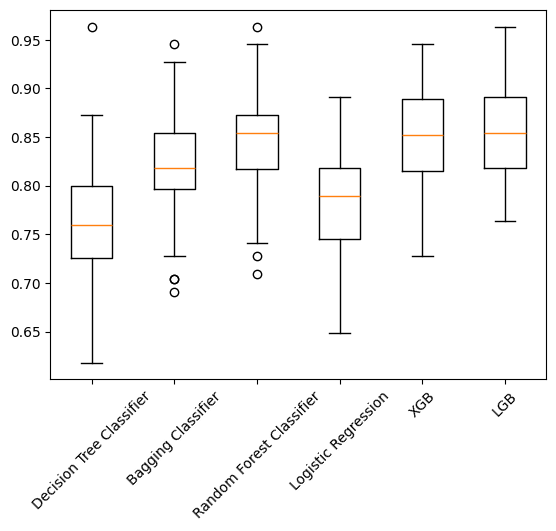

In [ ]:
models = {'Decision Tree Classifier': DecisionTreeClassifier(),
          'Bagging Classifier': BaggingClassifier(),
          'Random Forest Classifier': RandomForestClassifier(),
          'Logistic Regression': LogisticRegression(),
          'XGB':xgb.XGBClassifier(),
          'LGB':lgb.LGBMClassifier()
}

results = []
for model in models.values():
    kf = StratifiedKFold(n_splits=100,
                shuffle=True,
                random_state=42)
    score = cross_val_score(model,
                          X_train,
                          y_train,
                          cv=kf,
                          n_jobs=-1)
    results.append(score)


plt.boxplot(results, labels=models.keys())
plt.xticks(rotation=45)
plt.show()

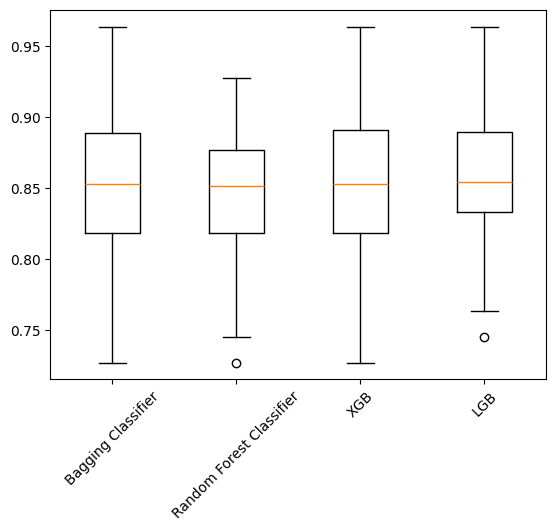

In [ ]:
models = {'Bagging Classifier': BaggingClassifier(n_estimators=100),
          'Random Forest Classifier': RandomForestClassifier(n_estimators=111),
          'XGB':xgb.XGBClassifier(booster='gbtree',
                                  objective='reg:logistic',
                                  n_estimators=61),
          'LGB':lgb.LGBMClassifier(n_estimators=89)
}

results = []
for model in models.values():
    kf = StratifiedKFold(n_splits=100,
                shuffle=True,
                random_state=42)
    score = cross_val_score(model,
                          X_train,
                          y_train,
                          cv=kf,
                          n_jobs=-1)
    results.append(score)


plt.boxplot(results, labels=models.keys())
plt.xticks(rotation=45)
plt.show()

                                                                !!!КІНЦЕВИЙ РЕЗУЛЬТАТ!!!

In [ ]:
                                                                !!!КІНЦЕВИЙ РЕЗУЛЬТАТ!!!

In [ ]:
                                                                !!!КІНЦЕВИЙ РЕЗУЛЬТАТ!!!

In [ ]:
                                                                !!!КІНЦЕВИЙ РЕЗУЛЬТАТ!!!

Ensemle

In [68]:
# classifiers = [
               # ('Bagging Classifier', Pipeline(steps_bc)),
               # ('Random Forest Classifier', Pipeline(steps_rf)),
               # ('XGB', Pipeline(steps_xgb)),
               # ('LGB', Pipeline(steps_lgb))]

classifiers = [
               ('Bagging Classifier', model_bc),
               # ('Random Forest Classifier', model_rf),
               ('XGB', model_xgb),
               ('LGB', model_lgb),
]

# for clf_name, clf in classifiers:

#     clf.fit(X_train, y_train)
#     accuracy = clf.score(X_test, y_test)
#     print('{:s} : {:.3f}'.format(clf_name, accuracy))

In [69]:
vc = VotingClassifier(estimators = classifiers)

vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Voting Classifier: {:.4f}'.format(accuracy))

Voting Classifier: 0.8802


In [22]:
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1226
           1       0.85      0.91      0.88      1120

    accuracy                           0.88      2346
   macro avg       0.88      0.88      0.88      2346
weighted avg       0.88      0.88      0.88      2346

[[1043  183]
 [  98 1022]]


In [ ]:
[[1050  176]
 [ 117 1003]]

new_df

In [9]:
df_new_1 = df_new
df_new_1['deposit'] = df_new_1['deposit'].astype('int8')

for i in df_new_1.columns:
    if df_new_1[i].dtype == 'bool':
        df_new_1[i] = df_new_1[i].astype('int8')

In [10]:
X_1 = df_new_1.drop('deposit', axis=1).values
y_1 = df_new_1.deposit.values
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.3)

In [13]:
from tpot import TPOTClassifier



tpot = TPOTClassifier(generations=5, 
                      population_size=20, 
                      verbosity=2, 
                      warm_start=True, 
                      random_state=42, 
                      max_time_mins=10,
                      cv=5,
                      n_jobs=-1)

num_iterations = 10

for iteration in range(num_iterations):
    print(f"Starting iteration {iteration+1}")
    tpot.fit(X_train_1, y_train_1)
    tpot.export(f'tpot_iteration_{iteration+1}_pipeline.py')

# Экспорт окончательного пайплайна
tpot.export('tpot_final_pipeline.py')

y_pred = tpot_clf.predict(X_test_1)

accuracy = accuracy_score(y_test_1, y_pred)
print(classification_report(y_test_1, y_pred))
print(confusion_matrix(y_test_1, y_pred))
print("Accuracy:", accuracy)

Starting iteration 1
Optimization Progress:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:37<00:02,  2.67s/pipeline]

  File "C:\Users\ASUS-X515EP\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


                                                                                                                       
Generation 1 - Current best internal CV score: 0.8455774544422463
                                                                                                                       
                                                                                                                       
TPOT closed during evaluation in one generation.
                                                                                                                       
                                                                                                                       
TPOT closed prematurely. Will use the current best pipeline.


C:\Users\ASUS-X515EP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tpot\base.py:1164: SyntaxWarning: invalid escape sequence '\w'
  (m.start(), m.end()) for m in re.finditer(", [\w]+__", dirty_string)

KeyboardInterrupt



TPOT

In [11]:
from tpot import TPOTClassifier
from sklearn.metrics import accuracy_score


tpot_clf = TPOTClassifier(generations=30,
                        population_size=100,
                        offspring_size=200,
                        scoring='accuracy',
                        verbosity=2,
                        random_state=42,
                        cv=4,
                        n_jobs=-1)


tpot_clf.fit(X_train_1, y_train_1)
print(tpot_clf.score(X_test_1, y_test_1))

joblib.dump(tpot_clf.fitted_pipeline_, 'tpot_model.pkl')

C:\Users\ASUS-X515EP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


                                                                                                                       
                                                                                                                       
TPOT closed during evaluation in one generation.
                                                                                                                       
                                                                                                                       
TPOT closed prematurely. Will use the current best pipeline.
                                                                                                                       
Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.15000000000000002, min_samples_leaf=4, min_samples_split=12, n_estimators=100)
0.8631713554987213


In [ ]:
y_pred = tpot_clf.predict(X_test_1)

accuracy = accuracy_score(y_test_1, y_pred)
print(classification_report(y_test_1, y_pred))
print(confusion_matrix(y_test_1, y_pred))
print("Accuracy:", accuracy)

LGBClassifier

In [29]:
def objective(trial):

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        # 'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 0.7),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.05, 0.7),
        'max_depth': trial.suggest_int('max_depth', 20, 40),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 120),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        # 'device': 'gpu',
        # 'gpu_platform_id': 0,  # ID платформы GPU (зависит от вашей конфигурации)
        # 'gpu_device_id': 0
        'tree_method': ['gpu_hist']
    }

    model = lgb.LGBMClassifier(n_jobs=-1, **params)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    return accuracy

study_lgb = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.RandomSampler(seed=42))
study_lgb.optimize(objective, n_trials=1000)

[I 2024-04-16 23:50:22,197] A new study created in memory with name: no-name-475ce031-5ff9-42b8-ac19-f1cacc38222c
[I 2024-04-16 23:50:22,370] Trial 0 finished with value: 0.8759590792838875 and parameters: {'lambda_l2': 0.29345107725078556, 'max_depth': 39, 'learning_rate': 0.08659969709057025, 'n_estimators': 112, 'subsample': 0.5624074561769746}. Best is trial 0 with value: 0.8759590792838875.
[I 2024-04-16 23:50:22,473] Trial 1 finished with value: 0.8742540494458653 and parameters: {'lambda_l2': 0.15139643821853171, 'max_depth': 21, 'learning_rate': 0.09330880728874677, 'n_estimators': 112, 'subsample': 0.7832290311184182}. Best is trial 0 with value: 0.8759590792838875.
[I 2024-04-16 23:50:22,586] Trial 2 finished with value: 0.8716965046888321 and parameters: {'lambda_l2': 0.06337992129227159, 'max_depth': 40, 'learning_rate': 0.09162213204002109, 'n_estimators': 104, 'subsample': 0.5727299868828403}. Best is trial 0 with value: 0.8759590792838875.
[I 2024-04-16 23:50:22,690] Tri

KeyboardInterrupt: 

In [27]:
print("Number of finished trials:", len(study_lgb.trials))
print("Best trial:")
trial_lgb = study_lgb.best_trial

print(f"  Value: {trial_lgb.value}")
print("  Params: ")
for key, value in trial_lgb.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 5
Best trial:
  Value: 0.8759590792838875
  Params: 
    lambda_l2: 0.29345107725078556
    max_depth: 39
    learning_rate: 0.08659969709057025
    n_estimators: 112
    subsample: 0.5624074561769746


In [44]:
params_lgb = {'lambda_l2': 0.2062076245843325,
          'max_depth': 35, 'learning_rate': 0.07937674848847602,
          'n_estimators': 118, 'subsample': 0.7922341631651393}

model_lgb = lgb.LGBMClassifier(objective='binary',
                            metric='binary_logloss',
                            boosting_type='gbdt',
                            verbose=-1,
                            **params_lgb)



model_lgb.fit(X_train, y_train)
model_lgb.score(X_test, y_test)

0.8789428815004262

In [45]:
steps_lgb = [('imputer', StandardScaler()), ('lgb', model_lgb)]

RandomForestClassifier

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    model = RandomForestClassifier(random_state=42,
                                   **params)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    return accuracy

    # scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    # accuracy = scores.mean()
    # return accuracy

study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study_rf.optimize(objective, n_trials=5)

[I 2024-04-13 23:04:07,713] A new study created in memory with name: no-name-0d192ccf-98ae-46b0-8664-5c5a1328ff59
[I 2024-04-13 23:04:08,975] Trial 0 finished with value: 0.8572037510656436 and parameters: {'n_estimators': 218, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8572037510656436.
[I 2024-04-13 23:04:10,633] Trial 1 finished with value: 0.8486786018755328 and parameters: {'n_estimators': 321, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8572037510656436.
[I 2024-04-13 23:04:11,802] Trial 2 finished with value: 0.860613810741688 and parameters: {'n_estimators': 187, 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with value: 0.860613810741688.
[I

In [ ]:
print("Number of finished trials:", len(study_rf.trials))
print("Best trial:")
trial_rf = study_rf.best_trial

print(f"  Value: {trial_rf.value}")
print("  Params: ")
for key, value in trial_rf.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 50
Best trial:
  Value: 0.8691389599317988
  Params: 
    n_estimators: 870
    max_depth: 37
    min_samples_split: 11
    min_samples_leaf: 2
    max_features: sqrt
    bootstrap: True
    criterion: entropy


In [46]:
params_rf = {'n_estimators': 217, 'max_depth': 19,
             'min_samples_split': 18, 'min_samples_leaf': 1,
             'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}

model_rf = RandomForestClassifier(random_state=42,
                                  **params_rf)
model_rf.fit(X_train, y_train)
model_rf.score(X_test, y_test)

0.8716965046888321

In [47]:
steps_rf = [('imputer', StandardScaler()), ('rf', model_rf)]

XGBClassifier

In [34]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.03, 0.1)
    subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
    min_samples_leaf = trial.suggest_float("min_samples_leaf", 0.05, 0.4)

    model = xgb.XGBClassifier(
        booster='gbtree',
        objective='reg:logistic',
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        # min_child_weight=min_child_weight,
        use_label_encoder=False,
        # eval_metric='logloss',
        random_state=42,
        n_jobs=1,
        tree_method='gpu_hist',
        device=cuda
        
    )

    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    return accuracy

    # scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    # accuracy = scores.mean()
    # return accuracy

study_xgb = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.RandomSampler(seed=42))
study_xgb.optimize(objective, n_trials=250)

[I 2024-04-16 23:54:14,018] A new study created in memory with name: no-name-8edd1deb-0bf2-4859-83e9-581944c922bb
C:\Users\ASUS-X515EP\AppData\Local\Temp\ipykernel_11384\3328112578.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.03, 0.1)
C:\Users\ASUS-X515EP\AppData\Local\Temp\ipykernel_11384\3328112578.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
C:\Users\ASUS-X515EP\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:54:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf

KeyboardInterrupt: 

In [ ]:
print("Number of finished trials:", len(study_xgb.trials))
print("Best trial:")
trial_xgb = study_xgb.best_trial

print(f"  Value: {trial_xgb.value}")
print("  Params: ")
for key, value in trial_xgb.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 1000
Best trial:
  Value: 0.8772378516624041
  Params: 
    n_estimators: 161
    max_depth: 7
    learning_rate: 0.0856955661247122
    subsample: 0.6096069936790222
    colsample_bytree: 0.9879326279095657
    min_child_weight: 4


In [48]:
params_xgb = {'n_estimators': 417,
              'max_depth': 22,
              'learning_rate': 0.02807781032420078,
              'subsample': 0.8131571864427336,
              'min_child_weight': 14}
model_xgb = xgb.XGBClassifier(**params_xgb,
                            #  use_label_encoder=False,
                            #  eval_metric='logloss',
                             booster='gbtree',
                             objective='reg:logistic',
                             random_state=42)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.8780903665814151

In [49]:
steps_xgb = [('imputer', StandardScaler()), ('xgb', model_xgb)]

BaggingClassifier

In [14]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 60)
    max_samples = trial.suggest_float('max_samples', 0.7, 0.95)
    max_features = trial.suggest_float('max_features', 0.5, 0.95)
    bootstrap = trial.suggest_categorical('bootstrap', [True])
    bootstrap_features = trial.suggest_categorical('bootstrap_features', [True, False])

    model = BaggingClassifier(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        bootstrap=bootstrap,
        bootstrap_features=bootstrap_features,
        random_state=42,
        warm_start=True
    )

    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    return accuracy

    # score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    # return score

study_bc = optuna.create_study(direction='maximize',
                              sampler=optuna.samplers.RandomSampler(seed=42))
study_bc.optimize(objective, n_trials=5000)

[I 2024-04-14 05:51:46,497] A new study created in memory with name: no-name-5e137593-8a4b-4336-be58-0e5a66604db4
[I 2024-04-14 05:51:48,854] Trial 0 finished with value: 0.8427109974424553 and parameters: {'n_estimators': 54, 'max_samples': 0.937678576602479, 'max_features': 0.8293972738151323, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 0 with value: 0.8427109974424553.
[I 2024-04-14 05:51:51,334] Trial 1 finished with value: 0.8640238704177323 and parameters: {'n_estimators': 51, 'max_samples': 0.7145209030420498, 'max_features': 0.8897792655987208, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 1 with value: 0.8640238704177323.
[I 2024-04-14 05:51:54,190] Trial 2 finished with value: 0.8461210571184996 and parameters: {'n_estimators': 50, 'max_samples': 0.9424774630404985, 'max_features': 0.8745991883601898, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 1 with value: 0.8640238704177323.
[I 2024-04-14 05:51:56,023] Trial 3 finished w

KeyboardInterrupt: 

In [ ]:
print("Best trial:")
trial_bc = study_bc.best_trial

print("  Value: {}".format(trial_bc.value))
print("  Params: ")
for key, value in trial_bc.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.8657289002557544
  Params: 
    n_estimators: 57
    max_samples: 0.9073992339573194
    max_features: 0.8983777818386056
    bootstrap: True
    bootstrap_features: False


In [50]:
params_bc = {'n_estimators': 52, 'max_samples': 0.7732869325652533,
             'max_features': 0.9033511183345039, 'bootstrap': True,
             'bootstrap_features': False}
model_bc = BaggingClassifier(random_state=42,
                             **params_bc)

model_bc.fit(X_train, y_train)
model_bc.score(X_test, y_test)

0.8729752770673487

In [51]:
steps_bc = [('imputer', StandardScaler()), ('bc', model_bc)]